In [1]:
# Import neccessary libraries
try:
    import netCDF4
except ImportError:
    !pip install netCDF4
    import netCDF4

try:
    import xarray as xr
except ImportError:
    !pip install xarray
    import xarray as xr

from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [2]:
# Load Datasets
combined_dataset_daily = xr.open_dataset("./Data/Weather/SPARTACUS2-DAILY_COMBINED_2023_2024.nc")
combined_dataset_monthly = xr.open_dataset("./Data/Weather/SPARTACUS2-MONTHLY_COMBINED_2023_2024.nc")

# First Assesment

### Daily:

In [3]:
size_d = len(combined_dataset_daily)
variables_d = combined_dataset_daily.data_vars.keys()
rr_count_d = combined_dataset_daily["RR"].count().values
sa_count_d = combined_dataset_daily["SA"].count().values
tn_count_d = combined_dataset_daily["TN"].count().values
tx_count_d = combined_dataset_daily["TX"].count().values

print("Size of dataset: ", size_d)
print("Available Variables:")
print(variables_d)
print("Non-NaN count:")
print("RR: ", rr_count_d)
print("SA: ", sa_count_d)
print("TN: ", tn_count_d)
print("TX: ", tx_count_d)

Size of dataset:  4
Available Variables:
KeysView(Data variables:
    RR       (time, y, x) float64 1GB nan nan nan nan nan ... nan nan nan nan
    SA       (time, y, x) float64 1GB nan nan nan nan nan ... nan nan nan nan
    TN       (time, y, x) float64 1GB nan nan nan nan nan ... nan nan nan nan
    TX       (time, y, x) float64 1GB nan nan nan nan nan ... nan nan nan nan)
Non-NaN count:
RR:  61324321
SA:  77293747
TN:  77293016
TX:  77293016


### Monthly:

In [4]:
size_m = len(combined_dataset_monthly)
variables_m = combined_dataset_monthly.data_vars.keys()
rr_count_m = combined_dataset_monthly["RR"].count().values
sa_count_m = combined_dataset_monthly["SA"].count().values
tm_count_m = combined_dataset_monthly["TM"].count().values

print("Size of dataset: ", size_m)
print("Available Variables:")
print(variables_m)
print("Non-NaN count:")
print("RR: ", rr_count_m)
print("SA: ", sa_count_m)
print("TM: ", tm_count_m)

Size of dataset:  3
Available Variables:
KeysView(Data variables:
    RR       (time, y, x) float64 37MB nan nan nan nan nan ... nan nan nan nan
    SA       (time, y, x) float64 37MB nan nan nan nan nan ... nan nan nan nan
    TM       (time, y, x) float64 37MB nan nan nan nan nan ... nan nan nan nan)
Non-NaN count:
RR:  2013384
SA:  2537688
TM:  2537664


# Preemptive Calculations

In [5]:
# Calculate an average over Austria on daily basis
rainfall_daily = combined_dataset_daily["RR"].mean(dim = ["y", "x"])
sunshine_daily = (combined_dataset_daily["SA"] / 3600).mean(dim = ["y", "x"])
temp_daily = ((combined_dataset_daily["TN"] + combined_dataset_daily["TX"]) / 2).mean(dim = ["y", "x"])

# Calculate an average over Austria on monthly basis
rainfall_monthly_sum = combined_dataset_monthly["RR"].mean(dim = ["y", "x"])
sunshine_monthly_sum = (combined_dataset_monthly["SA"] / 3600).mean(dim = ["y", "x"])
temp_monthly = combined_dataset_monthly["TM"].mean(dim = ["y", "x"])

rainfall_monthly = rainfall_monthly_sum #/ combined_dataset_monthly.time.dt.daysinmonth
sunshine_monthly = sunshine_monthly_sum #/ combined_dataset_monthly.time.dt.daysinmonth

# Give monthly data the same timeindex as daily data
rainfall_monthly_daily = rainfall_monthly.resample(time = "1D").ffill().reindex(time = rainfall_daily.time)
sunshine_monthly_daily = sunshine_monthly.resample(time = "1D").ffill().reindex(time = sunshine_daily.time)
temp_monthly_daily = temp_monthly.resample(time = "1D").ffill().reindex(time = temp_daily.time)

# Calculate unusual weather events 
unusual_rainfall_high = rainfall_daily >= (1.95 * rainfall_monthly_daily)
unusual_rainfall_low  = rainfall_daily <= (0.05 * rainfall_monthly_daily)

unusual_sunshine_high = sunshine_daily >= (1.95 * sunshine_monthly_daily)
unusual_sunshine_low  = sunshine_daily <= (0.05 * sunshine_monthly_daily)

unusual_temp_high = temp_daily >= (1.95 * temp_monthly_daily)
unusual_temp_low  = temp_daily <= (0.05 * temp_monthly_daily)

# Extract time values for plotting
daily_time_values = rainfall_daily.time.values
monthly_time_values = rainfall_monthly.time.values

# new data set of average over Austria
dataset_aa = xr.Dataset({
    "rainfall": rainfall_daily,
    "sunshine": sunshine_daily,
    "temperature": temp_daily
})
dataset_cleaned = dataset_aa.reset_coords(drop = True)
df_aa = dataset_cleaned.to_dataframe().reset_index()
df_aa = df_aa[["rainfall","sunshine", "temperature"]] 

# Second Assessment

### Daily:

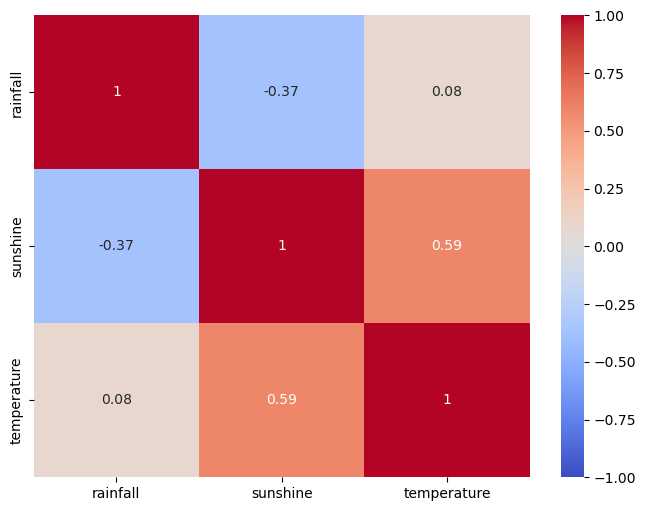

In [6]:
corr_matrix = df_aa.corr()

plt.figure(figsize = (8, 6))
sns.heatmap(corr_matrix, annot = True, cmap = "coolwarm", vmin = -1, vmax = 1)
plt.show()

Visualization of Correlation Matrix

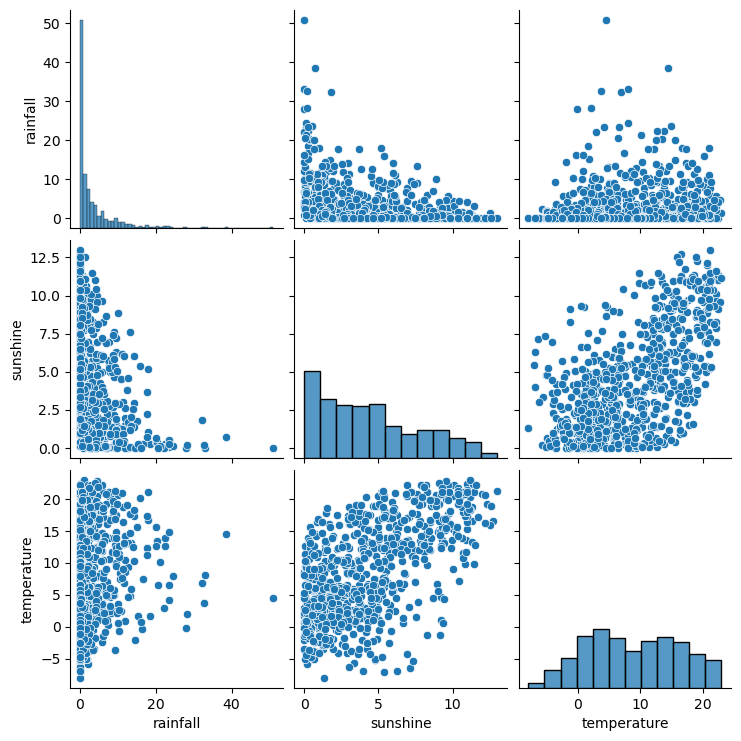

In [7]:
sns.pairplot(df_aa)
plt.show()

Better Histogram

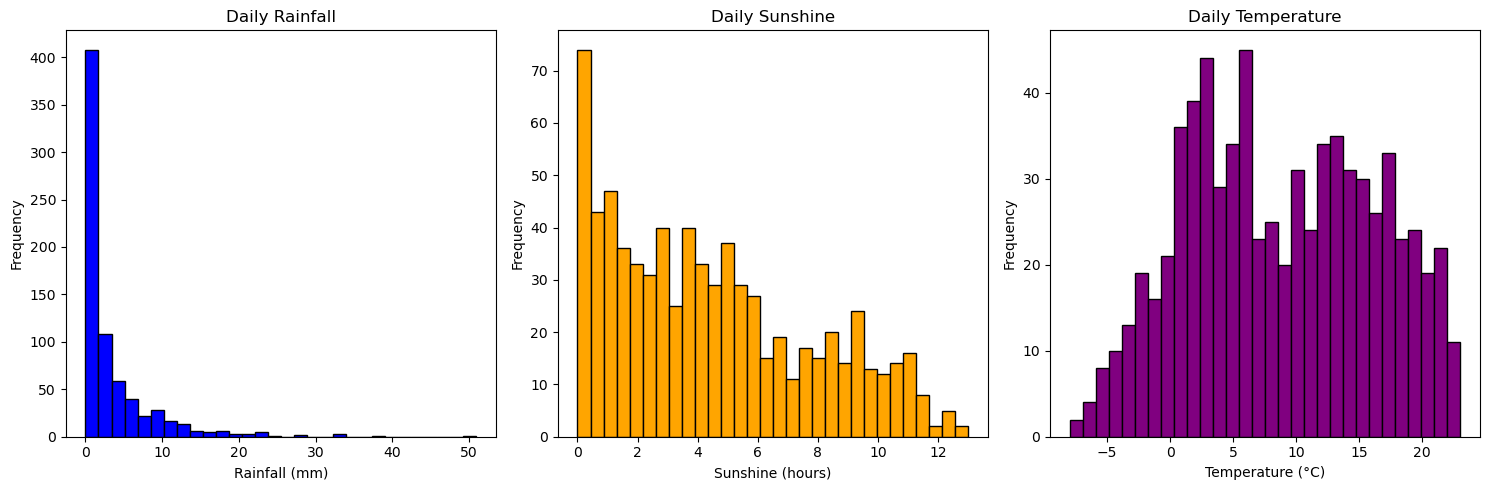

In [8]:
fig, axes = plt.subplots(1, 3, figsize = (15, 5)) 

# Histogram of daily rainfall
axes[0].hist(rainfall_daily, bins = 30, color = "blue", edgecolor = "black")
axes[0].set_title("Daily Rainfall")
axes[0].set_xlabel("Rainfall (mm)")
axes[0].set_ylabel("Frequency")

# Histogram of daily sunshine
axes[1].hist(sunshine_daily, bins = 30, color = "orange", edgecolor = "black")
axes[1].set_title("Daily Sunshine")
axes[1].set_xlabel("Sunshine (hours)")
axes[1].set_ylabel("Frequency")

# Histogram of daily temperature
axes[2].hist(temp_daily, bins = 30, color = "purple", edgecolor = "black")
axes[2].set_title("Daily Temperature")
axes[2].set_xlabel("Temperature (°C)")
axes[2].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

### Monthly:

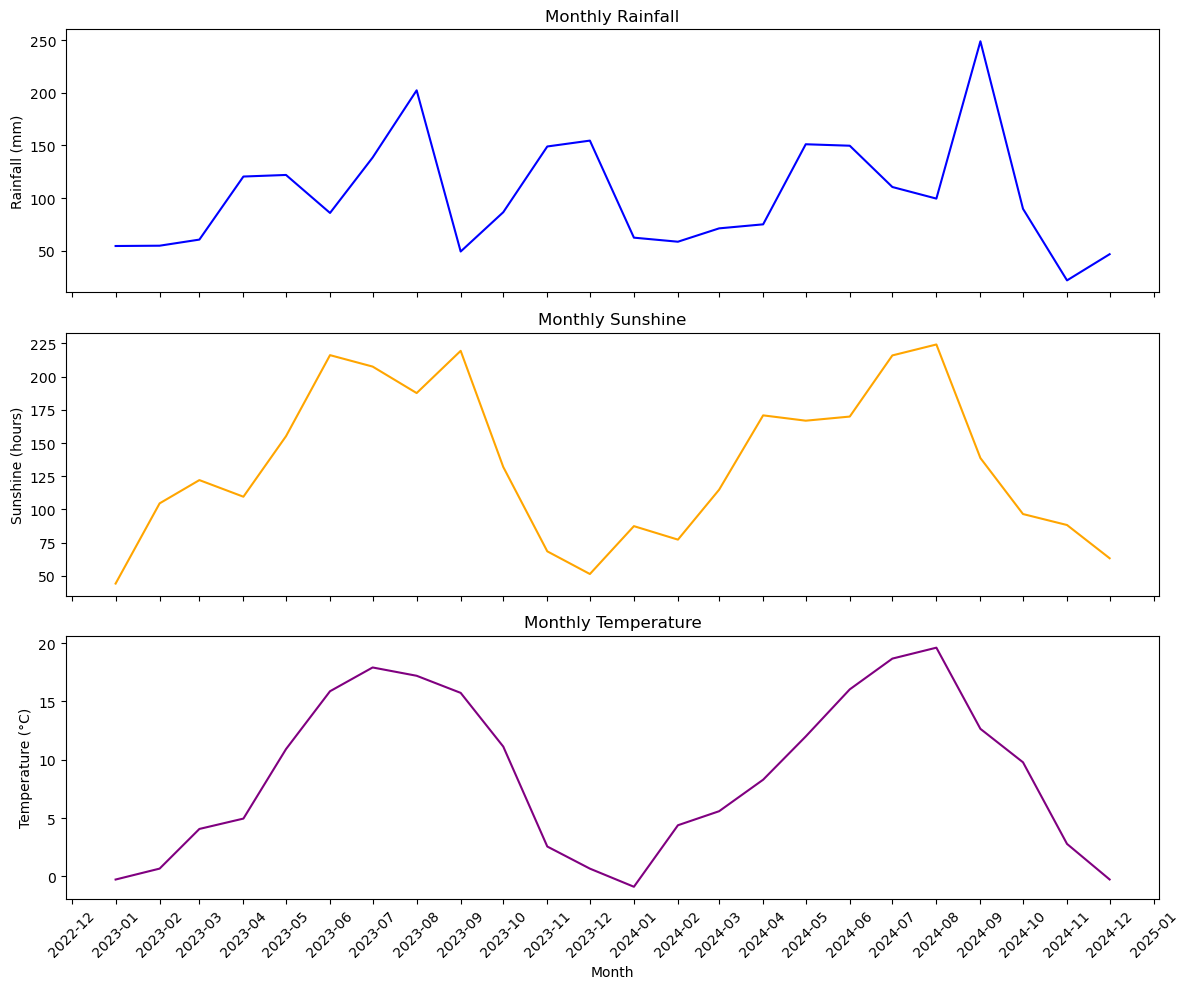

In [9]:
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex = True)

axs[0].plot(monthly_time_values, rainfall_monthly.values, color = "blue")
axs[0].set_ylabel("Rainfall (mm)")
axs[0].set_title("Monthly Rainfall")

axs[1].plot(monthly_time_values, sunshine_monthly.values, color = "orange")
axs[1].set_ylabel("Sunshine (hours)")
axs[1].set_title("Monthly Sunshine")

axs[2].plot(monthly_time_values, temp_monthly.values, color = "purple")
axs[2].set_ylabel("Temperature (°C)")
axs[2].set_title("Monthly Temperature")

axs[2].xaxis.set_major_locator(mdates.MonthLocator())
axs[2].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation = 45)
plt.xlabel("Month")
plt.tight_layout()
plt.show()

# Plotting unusual Weather Events:

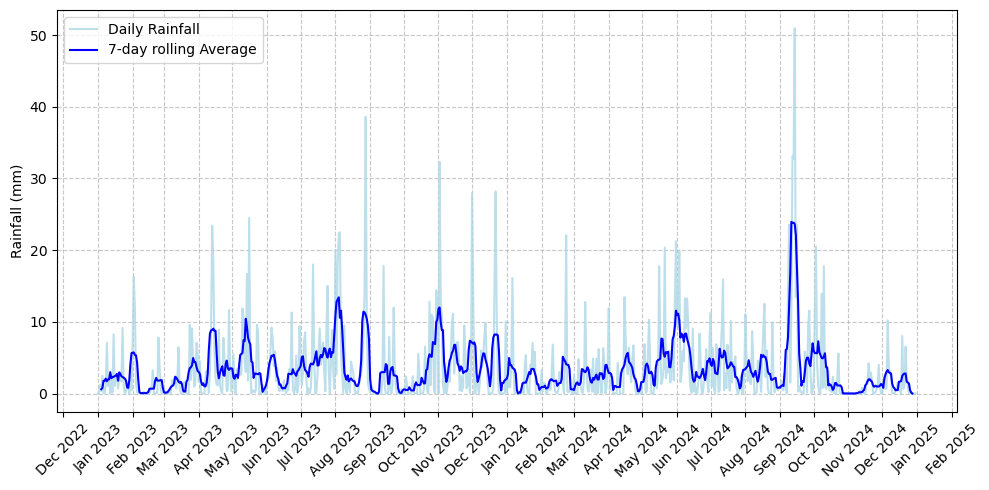

In [10]:
rainfall_smoothed = rainfall_daily.rolling(time = 7, center = True).mean()

fig, ax = plt.subplots(figsize = (10, 5))

ax.plot(daily_time_values, rainfall_daily.values, color = "lightblue", alpha = 0.8, label = "Daily Rainfall")
ax.plot(daily_time_values, rainfall_smoothed.values, color = "blue", label = "7-day rolling Average")

ax.set_ylabel("Rainfall (mm)")
ax.legend()

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.xticks(rotation = 45)
plt.grid(linestyle = "--", alpha = 0.7)
plt.tight_layout()
plt.show()

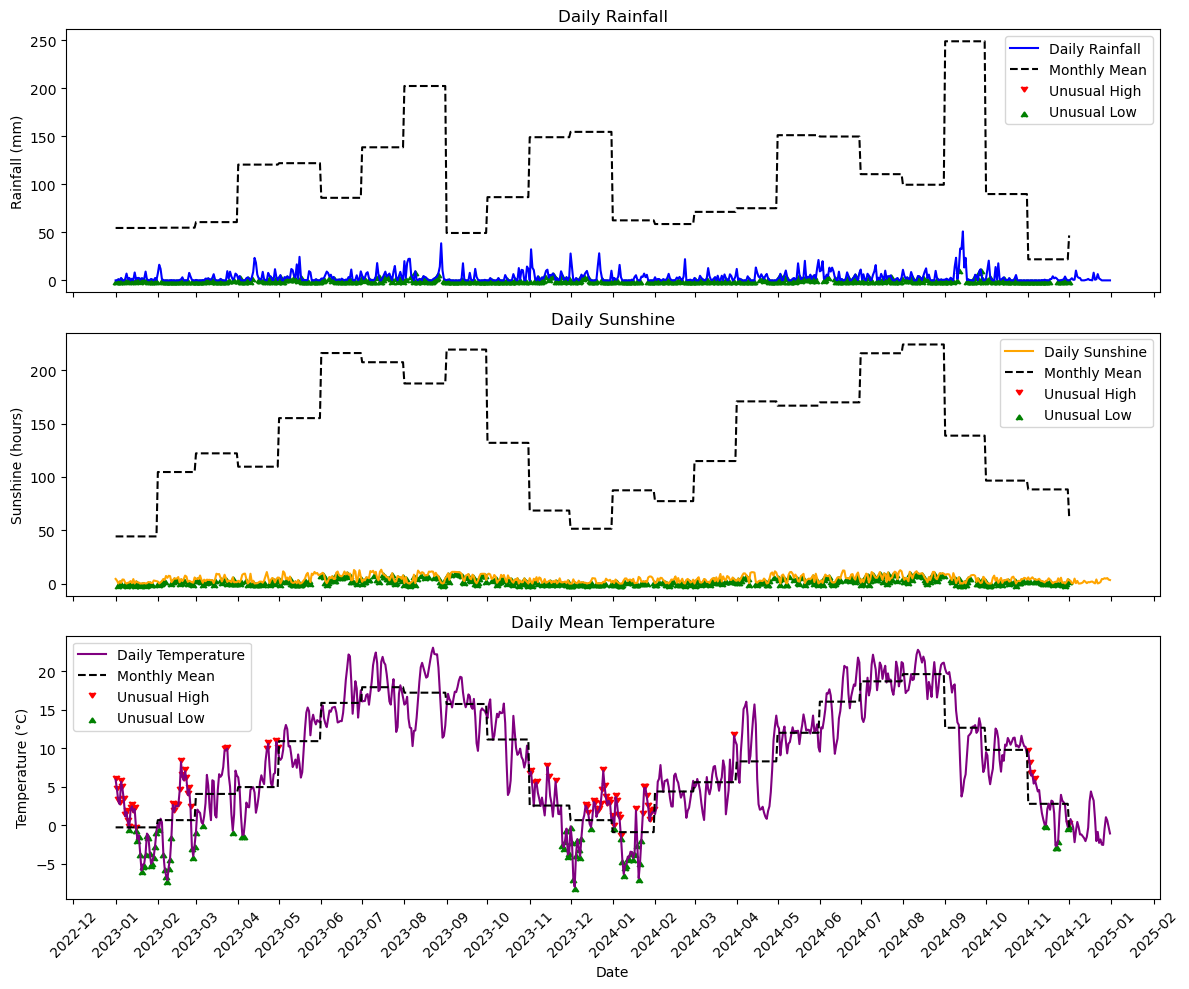

In [11]:
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex = True)

# Rainfall
axs[0].plot(daily_time_values, rainfall_daily.values, color = "blue", label = "Daily Rainfall")
axs[0].plot(daily_time_values, rainfall_monthly_daily.values, color = "black", linestyle = "--", label = "Monthly Mean")
axs[0].scatter(daily_time_values[unusual_rainfall_high.values], 
               rainfall_daily.values[unusual_rainfall_high.values], 
               color = "red",
               marker = 7,
               s = 20,
               label = "Unusual High")
axs[0].scatter(daily_time_values[unusual_rainfall_low.values], 
               rainfall_daily.values[unusual_rainfall_low.values],
               color = "green", 
               marker = 6,
               s = 20,
               label = "Unusual Low")
axs[0].set_ylabel("Rainfall (mm)")
axs[0].set_title("Daily Rainfall")
axs[0].legend()

# Sunshine
axs[1].plot(daily_time_values, sunshine_daily.values, color = "orange", label = "Daily Sunshine")
axs[1].plot(daily_time_values, sunshine_monthly_daily.values, color = "black", linestyle = "--", label = "Monthly Mean")
axs[1].scatter(daily_time_values[unusual_sunshine_high.values],
               sunshine_daily.values[unusual_sunshine_high.values],
               color = "red",
               marker = 7,
               s = 20,
               label = "Unusual High")
axs[1].scatter(daily_time_values[unusual_sunshine_low.values],
               sunshine_daily.values[unusual_sunshine_low.values],
               color = "green",
               marker = 6,
               s = 20,
               label = "Unusual Low")
axs[1].set_ylabel("Sunshine (hours)")
axs[1].set_title("Daily Sunshine")
axs[1].legend()

# Temperature
axs[2].plot(daily_time_values, temp_daily.values, color = "purple", label = "Daily Temperature")
axs[2].plot(daily_time_values, temp_monthly_daily.values, color = "black", linestyle = "--", label = "Monthly Mean")
axs[2].scatter(daily_time_values[unusual_temp_high.values], 
               temp_daily.values[unusual_temp_high.values],
               color = "red", 
               marker = 7, 
               s = 20,
               label = "Unusual High")
axs[2].scatter(daily_time_values[unusual_temp_low.values],
               temp_daily.values[unusual_temp_low.values],
               color = "green",
               marker = 6,
               s = 20,
               label = "Unusual Low")
axs[2].set_ylabel("Temperature (°C)")
axs[2].set_title("Daily Mean Temperature")
axs[2].legend()

axs[2].xaxis.set_major_locator(mdates.MonthLocator())
axs[2].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation = 45)
plt.xlabel("Date")

plt.tight_layout()
plt.show()